# 1. Sample weighting

Misclassifying a fraudulent transaction is typically worse than misclassifying a non-fraudulent transaction. The cost of misclassifying a fraudulent transaction as non-fraudulent is equal to the amount of the transaction, while for non-fraudulent transactions there is only a fixed administrative cost involved.

To take these costs into account, we can **weight the training samples**. Samples with a higher weight will contribute more to the loss than samples with a lower weight.

## 1.1 Train

### 1.1.1 Inspect dataset

We have already prepared the dataset as a pandas DataFrame that contains the misclassification costs (see column "**C_misclf**").

> **Note**: you can download the dataset [here](https://www.kaggle.com/datasets/mlg-ulb/creditcardfraud). Create a new folder called `data` in the directory of this notebook and move the downloaded csv file into that folder. Next, rename the csv file to `creditcard_fraud_dataset.csv`.

In [1]:
from lib.creditcard_fraud_dataset import get_train_test_dfs

df_train, df_test = get_train_test_dfs()

df_train

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V26,V27,V28,Amount,Class,scaled_amount,scaled_time,C_FP,C_FN,C_misclf
102120,68060.0,-4.565781,2.891870,-1.505909,-0.609598,-0.684404,-0.417628,0.093167,1.017300,0.817597,...,0.481573,0.055996,0.500978,43.92,0,0.306295,-0.195397,2,43.92,2.0
147630,88766.0,-1.932119,0.463690,-1.171450,-0.549980,1.710455,-1.030608,1.084965,-0.275486,0.535062,...,0.275663,0.269275,0.667690,14.17,0,-0.109411,0.047862,2,14.17,2.0
243316,151883.0,-0.657832,0.753651,1.229142,-0.180336,-0.355564,-0.479811,-0.106428,0.409319,0.231304,...,-0.127742,0.096903,0.095731,0.80,0,-0.296234,0.789377,2,0.80,2.0
259221,159020.0,-1.207027,1.737476,-0.948094,-0.456881,0.686600,-0.665881,0.405398,0.575671,-0.585687,...,0.035332,-0.401375,0.004993,3.91,0,-0.252777,0.873225,2,3.91,2.0
144969,86526.0,1.974552,0.176499,-2.080724,1.149523,0.845438,-0.908770,0.815385,-0.414188,-0.140411,...,-0.512841,-0.045404,-0.048915,59.70,0,0.526794,0.021546,2,59.70,2.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
119879,75618.0,1.173488,0.100792,0.490512,0.461596,-0.296377,-0.213165,-0.165254,0.119221,-0.114199,...,0.109235,-0.020922,0.003967,1.98,0,-0.279746,-0.106604,2,1.98,2.0
259178,159000.0,-0.775981,0.144023,-1.142399,-1.241113,1.940358,3.912076,-0.466107,1.360620,0.400697,...,-0.770941,0.066006,0.137056,89.23,0,0.939426,0.872990,2,89.23,2.0
131932,79795.0,-0.146609,0.992946,1.524591,0.485774,0.349308,-0.815198,1.076640,-0.395316,-0.491303,...,-0.398467,-0.121139,-0.196195,3.94,0,-0.252358,-0.057531,2,3.94,2.0
146867,87931.0,-2.948638,2.354849,-2.521201,-3.798905,1.866302,2.727695,-0.471769,2.217537,0.580199,...,0.426309,0.496912,0.335822,1.00,0,-0.293440,0.038053,2,1.00,2.0


Let's define variables that contain a *binary mask* to select fraudulent and non-fraudulent transactions.

In [2]:
is_fraud = df_train['Class'] == 1
no_fraud = df_train['Class'] == 0

As you can see, the misclassification cost is equal to the transaction amount if the transaction was fraudulent (when column **Class** is 1):

In [3]:
df_train[is_fraud]

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V26,V27,V28,Amount,Class,scaled_amount,scaled_time,C_FP,C_FN,C_misclf
149357,91075.0,-1.855061,1.554964,-1.405809,0.669327,-0.280230,1.178652,-3.459979,-2.815155,1.242229,...,-0.078591,0.366709,0.073767,38.76,1,0.234193,0.074989,2,38.76,38.76
43204,41413.0,-15.140450,7.378042,-16.356367,9.194935,-13.466163,-2.958431,-16.165539,10.075254,-7.901821,...,0.145964,-2.458680,-1.189888,106.55,1,1.181443,-0.508453,2,106.55,106.55
52521,45501.0,1.001992,0.047938,-0.349002,1.493958,0.186939,0.190966,-0.001112,0.147140,0.580415,...,-0.453206,0.046627,0.064698,105.99,1,1.173618,-0.460426,2,105.99,105.99
6108,6986.0,-4.397974,1.358367,-2.592844,2.679787,-1.128131,-1.706536,-3.496197,-0.248778,-0.247768,...,-0.657488,-0.827136,0.849573,59.00,1,0.517013,-0.912910,2,59.00,59.00
74794,55760.0,-6.003422,-3.930731,-0.007045,1.714669,3.414667,-2.329583,-1.901512,-2.746111,0.887673,...,-0.472412,1.775378,-0.104285,311.91,1,4.051003,-0.339901,2,311.91,311.91
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
42674,41194.0,-7.896886,5.381020,-8.451162,7.963928,-7.862419,-2.376820,-11.949723,5.051356,-6.912076,...,0.444577,1.101923,0.205958,1.52,1,-0.286173,-0.511026,2,1.52,1.52
33276,37167.0,-7.923891,-5.198360,-3.000024,4.420666,2.272194,-3.394483,-5.283435,0.131619,0.658176,...,0.520508,1.937421,-1.552593,12.31,1,-0.135401,-0.558336,2,12.31,12.31
182992,125612.0,1.889618,1.073099,-1.678018,4.173268,1.015516,-0.009389,-0.079706,0.064071,-0.714517,...,0.279556,0.031669,0.035883,3.22,1,-0.262419,0.480739,2,3.22,3.22
154697,102625.0,-4.221221,2.871121,-5.888716,6.890952,-3.404894,-1.154394,-7.739928,2.851363,-2.507569,...,-0.072429,0.136734,-0.599848,7.59,1,-0.201355,0.210682,2,7.59,7.59


The misclassification cost is equal to a fixed administrative cost if the transaction was non-fraudulent (column **Class** is 0):

In [4]:
df_train[no_fraud]

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V26,V27,V28,Amount,Class,scaled_amount,scaled_time,C_FP,C_FN,C_misclf
102120,68060.0,-4.565781,2.891870,-1.505909,-0.609598,-0.684404,-0.417628,0.093167,1.017300,0.817597,...,0.481573,0.055996,0.500978,43.92,0,0.306295,-0.195397,2,43.92,2.0
147630,88766.0,-1.932119,0.463690,-1.171450,-0.549980,1.710455,-1.030608,1.084965,-0.275486,0.535062,...,0.275663,0.269275,0.667690,14.17,0,-0.109411,0.047862,2,14.17,2.0
243316,151883.0,-0.657832,0.753651,1.229142,-0.180336,-0.355564,-0.479811,-0.106428,0.409319,0.231304,...,-0.127742,0.096903,0.095731,0.80,0,-0.296234,0.789377,2,0.80,2.0
259221,159020.0,-1.207027,1.737476,-0.948094,-0.456881,0.686600,-0.665881,0.405398,0.575671,-0.585687,...,0.035332,-0.401375,0.004993,3.91,0,-0.252777,0.873225,2,3.91,2.0
144969,86526.0,1.974552,0.176499,-2.080724,1.149523,0.845438,-0.908770,0.815385,-0.414188,-0.140411,...,-0.512841,-0.045404,-0.048915,59.70,0,0.526794,0.021546,2,59.70,2.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
119879,75618.0,1.173488,0.100792,0.490512,0.461596,-0.296377,-0.213165,-0.165254,0.119221,-0.114199,...,0.109235,-0.020922,0.003967,1.98,0,-0.279746,-0.106604,2,1.98,2.0
259178,159000.0,-0.775981,0.144023,-1.142399,-1.241113,1.940358,3.912076,-0.466107,1.360620,0.400697,...,-0.770941,0.066006,0.137056,89.23,0,0.939426,0.872990,2,89.23,2.0
131932,79795.0,-0.146609,0.992946,1.524591,0.485774,0.349308,-0.815198,1.076640,-0.395316,-0.491303,...,-0.398467,-0.121139,-0.196195,3.94,0,-0.252358,-0.057531,2,3.94,2.0
146867,87931.0,-2.948638,2.354849,-2.521201,-3.798905,1.866302,2.727695,-0.471769,2.217537,0.580199,...,0.426309,0.496912,0.335822,1.00,0,-0.293440,0.038053,2,1.00,2.0


### 1.1.2 Construct `X_train` (input) and `y_train` (expected output)

To train a classifier with [SciKit Learn](https://scikit-learn.org/stable/index.html), we need to provide the model inputs (`X_train`) and the expected model outputs (`y_train`). In our case, a single model input corresponds to the features of a single transaction. These features are contained in the columns `V1`-`V28`, `scaled_amount` and `scaled_time` of the DataFrame `df_train`. We can thus construct `X_train` as follows:

In [5]:
# The feature columns
X_COLS = ['V1', 'V2', 'V3', 'V4', 'V5', 'V6', 'V7', 'V8', 'V9', 'V10',
          'V11', 'V12', 'V13', 'V14', 'V15', 'V16', 'V17', 'V18', 'V19', 'V20',
          'V21', 'V22', 'V23', 'V24', 'V25', 'V26', 'V27', 'V28',
          'scaled_amount', 'scaled_time']

X_train = df_train[X_COLS]

The expected outputs are `1` if a transaction was fraudulent and `0` if it was not. This is contained in the column `Class` of `df_train`. As such, we can create `y_train` as:

In [6]:
y_train = df_train['Class']

### 1.1.3 Train logistic regression classifier *without* sample weighting

We can now use `X_train` and `y_train` to train a simple [`LogisticRegression`](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html) classifier. In `sklearn`, you can train a classifier by calling [`fit()`](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html#sklearn.linear_model.LogisticRegression.fit) on it and providde `X_train` and `y_train` as arguments.

In [7]:
from sklearn.linear_model import LogisticRegression

# Create a logistic regression classifier
clf = LogisticRegression(max_iter=500)

# Train it on X_train and y_train
clf.fit(X_train, y_train)

LogisticRegression(max_iter=500)

### 1.1.4 Train logistic regression classifier *with* sample weighting

To give more importance to fraudulent transactions, we can assign the values of columns **C_misclf** to the `sample_weight` argument of `fit()`.

In [8]:
# Create another logistic regression classifier
clf_weighted = LogisticRegression(max_iter=500)

# Train it on X_train and Y_train, using the 'C_misclf' column as sample weight
clf_weighted.fit(X_train, y_train, sample_weight=df_train['C_misclf'])

LogisticRegression(max_iter=500)

## 1.2 Evaluate

To evaluate our classifier, we compute the **Cost Precision** and the **Cost Recall**. These are similar to the well-known *precision* and *recall*, but are defined in terms of the *monetary value* of the predictions. More specifically, these metrics are defined as:

$$
\begin{aligned}
\text{Cost Precision} &= \frac{\text{TP}_\text{Amount}}{\text{TP}_\text{Amount} + \text{FP}_\text{Amount}}\\\\
&= \frac{\text{Value of correctly predicted fraudulent}}{\text{Value of predicted fraudulent}}
\end{aligned}
$$

$$
\begin{aligned}
\text{Cost Recall} &= \frac{\text{TP}_\text{Amount}}{\text{TP}_\text{Amount} + \text{FN}_\text{Amount}}\\\\
&= \frac{\text{Value of correctly predicted fraudulent}}{\text{Value of all fraudulent}}
\end{aligned}
$$

### 1.2.1 Construct `X_test` (input) and `y_test` (expected output)

To evaluate our classifiers, we use the separate test set. As before, we put the model inputs and expected outputs in two separate variables.

In [9]:
X_test = df_test[X_COLS]   # Model inputs
y_test = df_test['Class']  # Expected outputs

### 1.2.2 Classify test data

Our classifier have a method `predict()` to which we can pass `X_test` and which returns the prediction for each row in `X_test`.

In [10]:
# Unweighted classifier predictions
y_pred_unweighted = clf.predict(X_test)

# Weighted classifier predictions
y_pred_weighted = clf_weighted.predict(X_test)

Just as a reference, we will also include the predictions of a *naive* classifier that classifies *all transactions as non-fraudulent*.

In [11]:
import numpy as np

# Naive classifier: all transactions are non-fraudulent
y_pred_naive_accept = np.zeros_like(y_test)

### 1.2.3 Compute evaluation metrics

Now we can compare the predictions of our weighted, unweighted and naive classifier by computing the Cost Precision and Cost Recall, along with some other metrics (the metrics are returned as Python dictionary). We have implemented these metrics in the file `lib/cs_eval.py` (function `evaluate_pred()`). Feel free to take a look!

Note that these methods require the amount of each transaction, so that Cost Precision and Cost Recall can be computed correctly.

In [12]:
from lib.cs_eval import evaluate_pred

# Get the transaction amounts
amounts = df_test['Amount']

# Compute metrics for each classifier
eval_metrics_naive_accept = evaluate_pred(y_test, y_pred_naive_accept, amounts)
eval_metrics_unweighted   = evaluate_pred(y_test, y_pred_unweighted,   amounts)
eval_metrics_weighted     = evaluate_pred(y_test, y_pred_weighted,     amounts)

/vsc-hard-mounts/leuven-data/342/vsc34259/maibi_ba/cost_sensitive_learning/lib/cs_eval.py:21: RuntimeWarning: invalid value encountered in double_scalars
  'Cost Precision': tp_amount/(tp_amount + fp_amount),


### 1.2.4 Create DataFrame with evaluation results

To make visualization easier, we first put the evaluation metrics together in a DataFrame. We use some syntactic sugar to merge the dictionary returned by `evaluate_pred()` into a dictionary that represents a single DataFrame row.

In [13]:
import pandas as pd

df = pd.DataFrame([
    {
        'Method': 'Naive accept',
        **eval_metrics_naive_accept
    },
    {
        'Method': 'Unweighted',
        **eval_metrics_unweighted
    },
    {
        'Method': 'Weighted',
        **eval_metrics_weighted
    },
])

Let's take a look at the DataFrame we created.

In [14]:
df

,Method,Cost Precision,Cost Recall,TP Amount,FP Amount,FN Amount,Net Recovered Amount
0,Naive accept,NaN,0.000000,0.00,0.0,31256.57,-31256.57
1,Weighted,0.954289,0.829544,25928.71,1242.0,5327.86,19358.85
2,Unweighted,0.997766,0.514306,16075.45,36.0,15181.12,858.33


### 1.2.5 Visualize evaluation results

Using the DataFrame created above, we can visualize the Cost Precision and the Cost Recall of our classifiers. We use the plotting library [Seaborn](https://seaborn.pydata.org/) for this.

<AxesSubplot:xlabel='Method', ylabel='Cost Recall'>

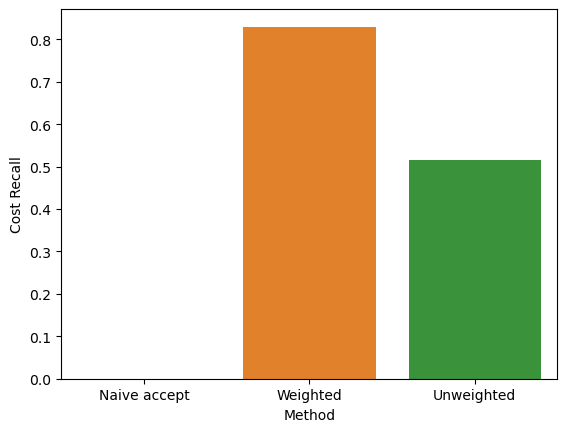

In [15]:
import seaborn as sns

sns.barplot(data=df, x='Method', y='Cost Recall')

<AxesSubplot:xlabel='Method', ylabel='Cost Precision'>

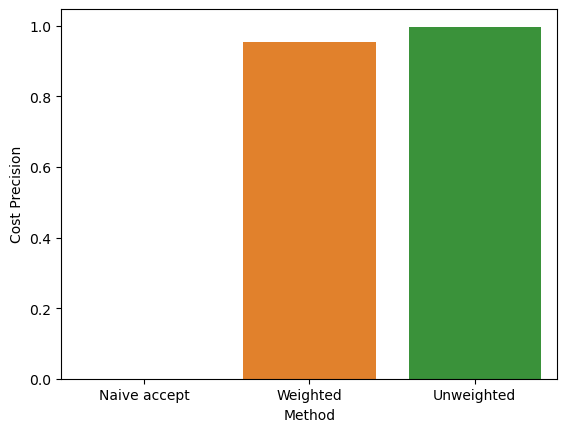

In [16]:
sns.barplot(data=df, x='Method', y='Cost Precision')